# Sentiment Analysis
Use the newsapi to pull the latest news articles for Microsoft and create a DataFrame of sentiment scores.

In [1]:
# Initial imports
import os
import pandas as pd
import yfinance as yf
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from newsapi import NewsApiClient
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/soma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Read the api key environment variable**

In [2]:
load_dotenv()

True

In [3]:
COMPANY_NAME = 'Microsoft Corporation'
STOCK_TICKER = 'MSFT'
START_DATE = '2011-01-01'
END_DATE = '2021-05-31'

**Load the Microsoft closing prices data**

In [4]:
stock_df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
stock_df['Pct_change'] = stock_df['Close'].pct_change()
# stock_df['Pct_change_1'] = stock_df['Close'].pct_change().shift()
# stock_df['Pct_change_2'] = stock_df['Close'].pct_change().shift(-1)
stock_df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
stock_df.reset_index(inplace=True)
stock_df.tail(15)

,Date,Open,High,Low,Close,Adj Close,Volume,Pct_change
2603,2021-05-10,250.869995,251.729996,247.119995,247.179993,246.610550,29299900,-0.020914
2604,2021-05-11,244.550003,246.600006,242.570007,246.229996,245.662735,33641600,-0.003843
2605,2021-05-12,242.169998,244.380005,238.070007,239.000000,238.449402,36684400,-0.029363
2606,2021-05-13,241.800003,245.600006,241.419998,243.029999,242.470108,29624300,0.016862
2607,2021-05-14,245.580002,249.179993,245.490005,248.149994,247.578308,23868600,0.021067
2608,2021-05-17,246.550003,246.589996,243.520004,245.179993,244.615158,24970200,-0.011969
2609,2021-05-18,246.270004,246.410004,242.899994,243.080002,242.520004,20168000,-0.008565
2610,2021-05-19,239.309998,243.229996,238.600006,243.119995,243.119995,25739800,0.000165
2611,2021-05-20,243.960007,247.949997,243.860001,246.479996,246.479996,21800700,0.013820
2612,2021-05-21,247.570007,248.330002,244.740005,245.169998,245.169998,21863100,-0.005315


In [6]:
stock_df.to_csv('Resources/MSFT_df.csv')

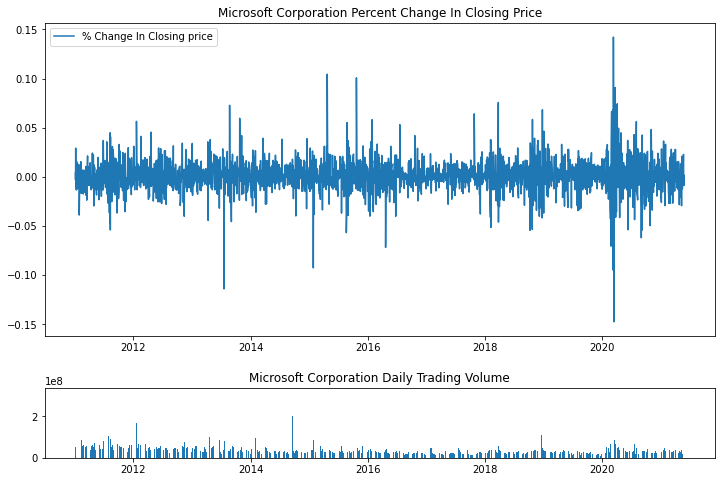

In [7]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(stock_df['Date'], stock_df['Pct_change'], label = '% Change In Closing price')
plt.title(COMPANY_NAME+ ' Percent Change In Closing Price')
plt.legend(loc=2)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(stock_df["Date"], stock_df["Volume"])
plt.title(COMPANY_NAME+' Daily Trading Volume')
plt.gcf().set_size_inches(12,8)
plt.subplots_adjust(hspace=0.75)

In [8]:
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date

In [9]:
stock_df = stock_df.set_index('Date')

**Create a newsapi client**

To get access of all the latest articles about Amazon company, we need to call NewsApiClient by passing NEWS_API_KEY.

In [10]:
newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))

**Fetch the Amazon news articles from newsapi.org by using get_everything function**

get_everything returns articles from large and small news sources and blogs.

In [11]:
stock_news_articles = newsapi.get_everything(
    q = "Microsoft AND MSFT",
    language = "en",
    page_size = 100,
    sort_by = "relevancy"
)

**Define sentiment dataframe function which is used to create Microsoft sentiment scores**

In [12]:
def get_sentiments_df(articles):
    # Create the sentiment scores DataFrame
    sentiments = []
    for article in articles["articles"]:
        try:
            text = article["description"]
            date = article["publishedAt"][:20]
            sentiment = analyzer.polarity_scores(text)
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]

            sentiments.append({
                "Text": text,
                "Date": date,
                "Compound": compound,
                "Positive": pos,
                "Negative": neg,
                "Neutral": neu

            })

        except AttributeError:
            pass
        
    # Create DataFrame
    df = pd.DataFrame(sentiments)
    
    # Reorder DataFrame columns
    cols = ["Date", "Text", "Compound", "Positive", "Negative", "Neutral"]
    df = df[cols]
    
    return df

**Create Stock sentiment scores DataFrame**

Here we use get_sentiments_df function by passing stock_news_articles argument for Microsoft news article.

In [13]:
stock_sentiment_df = get_sentiments_df(stock_news_articles)
stock_sentiment_df.head()

,Date,Text,Compound,Positive,Negative,Neutral
0,2021-06-06T15:48:39Z,Microsoft blocked images and videos around the...,-0.7351,0.000,0.187,0.813
1,2021-05-28T09:26:24Z,The hackers behind one of the worst data breac...,-0.5574,0.040,0.109,0.851
2,2021-05-20T21:26:15Z,Summary List PlacementA key component of a wel...,-0.3818,0.000,0.066,0.934
3,2021-06-03T22:47:00Z,"In late February 2020, Microsoft carried out t...",0.7184,0.133,0.000,0.867
4,2021-05-18T19:57:45Z,Summary List PlacementEmployees exhausted afte...,-0.8126,0.000,0.251,0.749


**Describe the stock Sentiment**

The describe function gives a summary of statistics of stock_sentiment_df dataframe.

In [14]:
stock_sentiment_df.describe()

,Compound,Positive,Negative,Neutral
count,100.000000,100.000000,100.00000,100.000000
mean,0.205950,0.111090,0.03747,0.851420
std,0.398819,0.115718,0.06351,0.124187
min,-0.812600,0.000000,0.00000,0.413000
25%,0.000000,0.000000,0.00000,0.783000
50%,0.204000,0.084000,0.00000,0.865000
75%,0.546075,0.189000,0.06525,0.936250
max,0.895700,0.587000,0.32500,1.000000


In [15]:
stock_scores_df = pd.DataFrame(stock_sentiment_df[['Date', 'Compound', 'Positive', 'Negative', 'Neutral']])
# Convert the date column from string to datetime
stock_scores_df['Date'] = pd.to_datetime(stock_scores_df['Date']).dt.date
stock_scores_df = stock_scores_df.groupby(['Date']).mean()
# stock_scores_df1 = stock_scores_df.groupby(['Date']).mean().shift()
# stock_scores_df2 = stock_scores_df.groupby(['Date']).mean().shift(-1)
stock_scores_df.tail(20)

,Compound,Positive,Negative,Neutral
Date,,,,
2021-05-19,0.080500,0.200000,0.058000,0.742000
2021-05-20,0.160900,0.089500,0.045875,0.864375
2021-05-21,0.339338,0.153375,0.028375,0.818250
2021-05-22,0.778300,0.236000,0.000000,0.764000
2021-05-24,0.177025,0.078250,0.049500,0.872000
2021-05-25,0.025800,0.146000,0.108000,0.746000
2021-05-26,0.425833,0.127000,0.000000,0.873000
2021-05-27,0.190900,0.055000,0.000000,0.945000
2021-05-28,0.088343,0.080857,0.043000,0.876143


**Let us join `ticker_scores_df` and `ticker_df` dataframes**

In [16]:
# join it with main dataframe
df = pd.merge(stock_df, stock_scores_df, on='Date', how='inner')
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Pct_change,Compound,Positive,Negative,Neutral
Date,,,,,,,,,,,
2021-05-24,247.789993,251.160004,247.509995,250.779999,250.779999,21411500,0.022882,0.177025,0.078250,0.0495,0.872000
2021-05-25,251.770004,252.750000,250.820007,251.720001,251.720001,17704300,0.003748,0.025800,0.146000,0.1080,0.746000
2021-05-26,251.429993,252.940002,250.750000,251.490005,251.490005,17771600,-0.000914,0.425833,0.127000,0.0000,0.873000
2021-05-27,251.169998,251.479996,249.250000,249.309998,249.309998,24426200,-0.008668,0.190900,0.055000,0.0000,0.945000
2021-05-28,251.000000,252.080002,249.559998,249.679993,249.679993,18270200,0.001484,0.088343,0.080857,0.0430,0.876143


In [17]:
df.to_csv('Resources/stock_scores_df.csv')

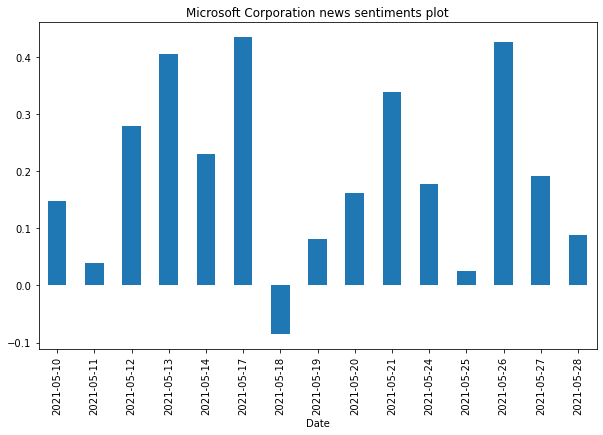

In [18]:
# Plot a bar chart with pandas
sentiment_plot = df['Compound'].plot.bar(x='Date', y='Compound', figsize=(10,6), title=COMPANY_NAME+' news sentiments plot')

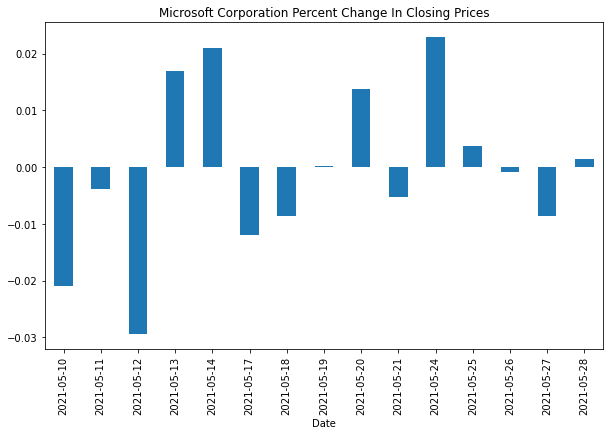

In [19]:
stock_price_plot = df['Pct_change'].plot.bar(x='Date', y='Pct_change', figsize=(10,6), title=COMPANY_NAME+' Percent Change In Closing Prices')

In [20]:
score_df = df[['Pct_change', 'Compound']]
score_df.tail()

,Pct_change,Compound
Date,,
2021-05-24,0.022882,0.177025
2021-05-25,0.003748,0.025800
2021-05-26,-0.000914,0.425833
2021-05-27,-0.008668,0.190900
2021-05-28,0.001484,0.088343


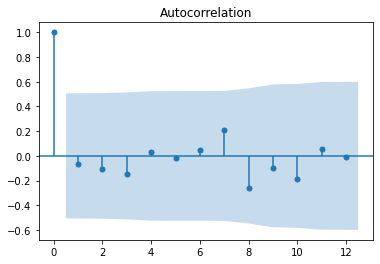

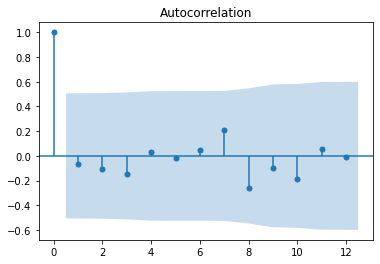

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the Closing Prices
plot_acf(score_df['Pct_change'])

In [22]:
X = score_df['Compound']
Y = score_df['Pct_change']
split_data = int(len(X)*0.7)

X_train, X_test = X[:split_data], X[split_data:]
Y_train, Y_test = Y[:split_data], Y[split_data:]

In [23]:
Y_test

Date
2021-05-24    0.022882
2021-05-25    0.003748
2021-05-26   -0.000914
2021-05-27   -0.008668
2021-05-28    0.001484
Name: Pct_change, dtype: float64

In [24]:
# Import the ARIMA model
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Configure ARIMA model with the order of (p, d, q)=(1,0,0) and use the independent 
# variables as the exogenous variables in the model. The ARIMA model where the exogenous variables are used is known as the ARIMAX model, where 
# 'X' represents exogenous variable.
model_ARIMA = ARIMA(endog=Y_train, exog=X_train, order=(1,0,0))
model_fit = model_ARIMA.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Pct_change   No. Observations:                   10
Model:                     ARMA(1, 0)   Log Likelihood                  27.661
Method:                       css-mle   S.D. of innovations              0.015
Date:                Wed, 09 Jun 2021   AIC                            -47.322
Time:                        20:57:48   BIC                            -46.111
Sample:                    05-10-2021   HQIC                           -48.649
                         - 05-21-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0066      0.008     -0.813      0.416      -0.023       0.009
Compound             0.0209      0.037      0.566      0.572      -0.052       0.094
ar.L1.Pct_change    -0.2208      0.389     -0.568      0.570      -0.983       0.541
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.5284           +0.0000j            4.5284            0.5000
-----------------------------------------------------------------------------
"""

In [25]:
Y_test_df = Y_test.to_frame('Actual')
Y_test_df

,Actual
Date,
2021-05-24,0.022882
2021-05-25,0.003748
2021-05-26,-0.000914
2021-05-27,-0.008668
2021-05-28,0.001484


In [26]:
predictions = model_fit.predict(start = len(X_train)-1, end = len(X)-1, exog=X_test)[1:]

In [27]:
predictions_df = predictions.to_frame('Predictions')
predictions_df.index.names = ['Date']
predictions_df

,Predictions
Date,
2021-05-24,-0.001656
2021-05-25,-0.006382
2021-05-26,0.002340
2021-05-27,-0.002656
2021-05-28,-0.004788


In [28]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse_Test_ARIMA = mean_squared_error(Y_test, predictions)
rmse_Test_ARIMA = sqrt(mean_squared_error(Y_test, predictions))
print(f"The mean squared error and the root mean squared error of the ARIMA model is {mse_Test_ARIMA} and {rmse_Test_ARIMA}")

The mean squared error and the root mean squared error of the ARIMA model is 0.00015816787427991582 and 0.012576480997477626


In [29]:
compound_pred_df = pd.concat([Y_test_df, predictions_df], axis='columns', join='inner')
# compound_pred_df.dropna(inplace=True)
compound_pred_df

,Actual,Predictions
Date,,
2021-05-24,0.022882,-0.001656
2021-05-25,0.003748,-0.006382
2021-05-26,-0.000914,0.002340
2021-05-27,-0.008668,-0.002656
2021-05-28,0.001484,-0.004788


<AxesSubplot:title={'center':'Comparison Between Percent Change In Closing Prices and Sentiment'}, xlabel='Date'>

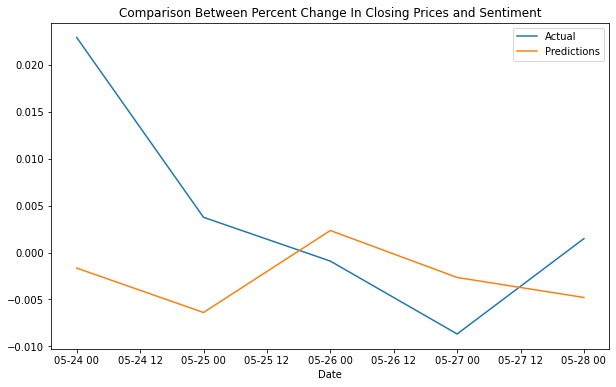

In [30]:
compound_pred_df.plot(title='Comparison Between Percent Change In Closing Prices and Sentiment', figsize=(10,6))

## Natural Language Processing
Tokenizer
In this section, we will use NLTK and Python to tokenize the text. We will perform the following tasks to preprocess the text:

Tokenization: Tokenization is a process of creating tokens by splitting the larger text into smaller sentences, words or phrases.
Lemmatization: It is a technique to standardize the words by ensuring that the root word that is also called lemma(dictionary form of word) belongs to the language.
Lowercase each word.
Remove Punctuation.
Remove Stopwords Stopwords are the words which does not add much meaning to the sentence, if we remove the stopwords the meaning of the sentence does not change.

In [31]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

**Instantiate the lemmatizer**

In [32]:
lemmatizer = WordNetLemmatizer()

**Create a list of stopwords**

In [33]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**Expand the default stopwords list**

In [34]:
exp_stop_words = [
    'This', 
    'said', 
    'ha', 
    'dont', 
    'youve', 
    'even', 
    'images',
    'getty',
    'com',
    'watch',
    'via', 
    'char'
    'li',
    'ol',
    'inc',
    'well',
    'originally',
    'illustration',
    'according',
    'general',
    'summary',
    'list',
    'placementan',
    'placementa',
    'placementamazon',
    'placementemployees',
    'still',
    'apple',
    'li'
    
]

**Define the tokenizer function to create a new tokens column for Stock dataframe**

Tokenization is a process of creating tokens by splitting the larger text into smaller sentences, words or phrases.

In [35]:
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub(' ', text)
    
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    
    # Remove the stop words
    sw = set(stopwords.words('english') + exp_stop_words)
    not_sw = [word for word in lem if word.lower() not in sw]
    
    # Convert the words to lowercase
    tokens = [word.lower() for word in not_sw]
    
    return tokens

**Create a new tokens column for Stock**

In [36]:
stock_tokens = []

for text in stock_sentiment_df['Text']:
    stock_tokens.append(tokenizer(text))
    
stock_sentiment_df['Tokens'] = stock_tokens
stock_sentiment_df.head()

,Date,Text,Compound,Positive,Negative,Neutral,Tokens
0,2021-06-06T15:48:39Z,Microsoft blocked images and videos around the...,-0.7351,0.000,0.187,0.813,"[microsoft, blocked, image, video, around, wor..."
1,2021-05-28T09:26:24Z,The hackers behind one of the worst data breac...,-0.5574,0.040,0.109,0.851,"[hacker, behind, one, worst, data, breach, eve..."
2,2021-05-20T21:26:15Z,Summary List PlacementA key component of a wel...,-0.3818,0.000,0.066,0.934,"[key, component, publicized, cloud, partnershi..."
3,2021-06-03T22:47:00Z,"In late February 2020, Microsoft carried out t...",0.7184,0.133,0.000,0.867,"[late, february, microsoft, carried, first, of..."
4,2021-05-18T19:57:45Z,Summary List PlacementEmployees exhausted afte...,-0.8126,0.000,0.251,0.749,"[exhausted, year, remote, work, making, mistak..."


**NGrams and Frequency Analysis**

In this section we will look at the ngrams and word frequency.

Use NLTK to produce the n-grams for N = 2.
List the top 10 words for stock.
Lets import Counter and ngrams function

We use Counter as a tool to count the key-value pairs in an object, it holds the elements as dictionary keys and their count as dic values. and also use ngrams which is a sequence of n words where n is a number of words.

In [37]:
from collections import Counter
from nltk import ngrams

**Define top 10 ngrams counts function to generate the n-grams of Stock**

Here we generate bigrams(combination of two words).

In [38]:
def ngrams_counts_top10(df, n):   
    stock_bigrams = []
    for tokens in df.Tokens:
        bigrams = ngrams(tokens, n)
        stock_bigrams.extend(bigrams)
    top_10 = dict(Counter(stock_bigrams).most_common(10))
    return pd.DataFrame(list(top_10.items()), columns=['bigram', 'count'])

In [39]:
ngrams_counts_top10(stock_sentiment_df, 2)

,bigram,count
0,"(tech, stock)",6
1,"(trading, session)",5
2,"(dividend, stock)",4
3,"(stock, market)",4
4,"(shares, international)",4
5,"(international, business)",4
6,"(business, machines)",4
7,"(machines, corp)",4
8,"(proved, around)",4
9,"(current, weakness)",3


**Function token_count generates the top 10 words for a given Stock**

In [40]:
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

*Use token_count function to get the top 10 words for Stock*

In [41]:
stock_tokens = []
for tokens in stock_sentiment_df.Tokens:
    stock_tokens.extend(tokens) 
token_count(stock_tokens, 10)

[('stock', 54),
 ('microsoft', 29),
 ('tech', 20),
 ('company', 13),
 ('growth', 10),
 ('could', 10),
 ('investor', 10),
 ('year', 9),
 ('business', 9),
 ('trading', 8)]

### Word Clouds

In this section, we will generate word clouds for stock to summarize the news.

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

**Function generate_wordcloud generates the word cloud**

In [43]:
def generate_wordcloud(df):
    stock_tokens = []
    for tokens in df.Tokens:
        stock_tokens.extend(tokens)
    input_text = ' '.join(stock_tokens)
    wc = WordCloud().generate(input_text)
    plt.imshow(wc)

*Use generate_wordcloud function to generate Stock word cloud*

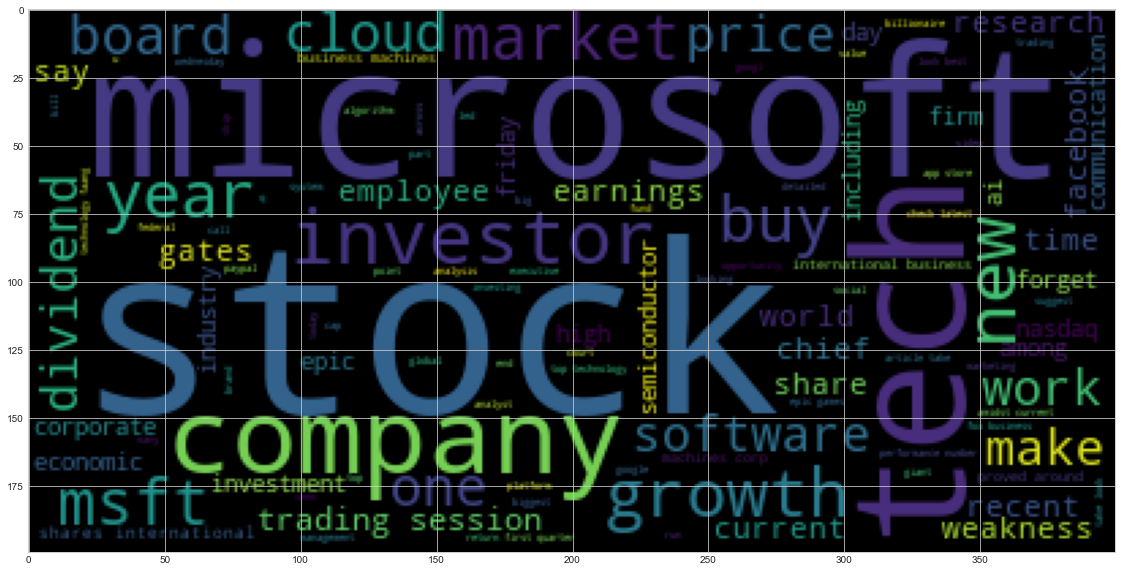

In [44]:
generate_wordcloud(stock_sentiment_df)

## Named Entity Recognition
In this section, we will build a named entity recognition model for , then visualize the tags using SpaCy.

In [45]:
import spacy
from spacy import displacy

**Download the language model for SpaCy**

In [46]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


**Load the spaCy model**

In [47]:
nlp = spacy.load('en_core_web_sm')

**Stock NER**

Concatenate all of the Stock text together

In [48]:
stock_text = stock_sentiment_df.Text.str.cat()

**Run the NER processor on all of the text**

In [49]:
stock_doc = nlp(stock_text)

**Add a title to the document**

In [50]:
stock_doc.user_data["title"] = COMPANY_NAME+" NER"

**Render the visualization**

In [51]:
displacy.render(stock_doc, style='ent')